# Coursera Capstone Project: Battle of the Neighborhoods

This notebook will be used specifically for completing the Applied Data Science capstone project in Coursera.

**Note: I used the same notebook for the entire course.**

**Note: I the magic command "%%capture" in some cells to remove the output and improve readability**

### Introduction

The main objective of this project is to determine what is the best neighborhood in Toronto to open an Indian Restaurant. This will be determined by the amount of Indian Restaurants that are nearby in each neighborhood. The neighboorhood with less Indian Restuarants nearby will theoretically be the best place to open one.

Data for this project will be obtained from different sources such as:
- Wikipedia (To obtain Toronto's boroughs, neighborhoods, and postal codes.)
- A CSV provided by Coursera with Toronto's neighborhoods coordinates.
- Foursquare (To obtain information about nearby venues in Toronto's neighborhoods.)

### Table of Contents

1. Installing Required Libraries
2. Scraping Wikipedia
3. Creating a Dataframe with Neighborhoods
4. Mapping Toronto's Neighborhoods
5. Obtaining Venues with Foursquare
6. Creating a Dataframe with Venues
7. Clustering Neighborhoods
8. Indian Restaurants by Cluster
9. Conclusion


### 1. Installing Required Libraries

For this project the following libraries will be used in order to extract, analyze, transform, and finally display the data.

In [2]:
%%capture

!pip install pandas
!pip install numpy==1.19.4
!pip install geopy
!pip install folium
!pip install beautifulsoup4
!pip install matplotlib
!pip install sklearn

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json # library to handle JSON files
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from IPython.display import Image # libraries for displaying images
from IPython.core.display import HTML # libraries for displaying images
from IPython.display import display
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # plotting library
import matplotlib.pyplot as plt 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 2. Scraping Wikipedia

First I got the neighborhood data from wikipedia using Beautiful Soup and created a dataframe

In [130]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

soup = BeautifulSoup(str(data_html))

Then I scraped the data to obtain the Postal Code, Borough and Neighborhood.

In [139]:
content=[]
table=soup.find('table')

for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        content.append(cell)

### 3. Creating a Dataframe with Neighborhoods

Using the data obtained from the previous step I created a pandas dataframe.

In [145]:
df=pd.DataFrame(content)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Then I saved the dataframe into a csv file.

In [146]:
df.to_csv('neighborhood-df.csv')

Then I dropped any unnecesary data like nulls and cells that contain "Not Assigned" value. Used the shape function to print the number of rows in the dataframe.

In [147]:
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)
df = df_dropna
df.shape

(103, 3)

Using a csv provided by Coursera I obtained the geo-coordiantes for each Postal Code.

In [148]:
coords_url = "https://cocl.us/Geospatial_data"

coords_df = pd.read_csv(coords_url)
coords_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
coords_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Then I merged both dataframes to create a single dataframe with all the data.

In [149]:
df = pd.merge(df, coords_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### 4. Mapping Toronto's Neighborhoods

To explore the dataframe I first counted the number of neighborhoods by each different borough.

In [150]:
df_toronto = df
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto                                                  9
Downtown Toronto                                                17
Downtown TorontoStn A PO Boxes25 The Esplanade                   1
East Toronto                                                     4
East TorontoBusiness reply mail Processing Centre969 Eastern     1
East York                                                        4
East YorkEast Toronto                                            1
Etobicoke                                                       11
EtobicokeNorthwest                                               1
MississaugaCanada Post Gateway Processing Centre                 1
North York                                                      24
Queen's Park                                                     1
Scarborough                                                     17
West Toronto                                                     6
York                                                  

Then I decided to obtain the coordinates for Toronto using the mean values of every postal code. This will be used to create a Folium map.

In [151]:
boroughs = df_toronto['Borough'].unique().tolist()
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()

print("Toronto Coordinates:",lat_toronto,",",lon_toronto)

Toronto Coordinates: 43.704607733980595 , -79.39715291165048


Then I assigned each borough a random color.

In [152]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

Finally, I created a Folium map to visualize the Toronto's neighborhoods colored by their respective boroughs.

In [153]:
m = folium.Map(location=[lat_toronto, lon_toronto])

for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7).add_to(m)
m

### 5. Obtaining Venues with Foursquare

First, I stored my Foursquare credentials in variables.

In [154]:
%%capture

CLIENT_ID='YZ2VEXJYI1SNN4WG4PYNGGKUE223OTCES4XDL2IMXDF3MM5X'
CLIENT_SECRET='DSWPWQTCQFN4KXDMYRPQ5AFG1VR5LRSBFBZRSQATYMHWPIQL'
VERSION = 20200514

Then I created a function that sends a request to Foursquares venues endpoint using my credentials. I limited the number of venues to 100.

In [155]:
def getVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    radius = 500
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### 6. Creating a Dataframe with Venues

I used the function created above to obtain the nearby venues using the previously created dataframe. I hid the results with metadata to improve readability.

In [176]:
%%capture

nearby_venues = getVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Here we can see the first 5 rows of the resulting dataframe.

In [177]:
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


Lets try looking if there is Indian Restaurant nearby.

In [178]:
"Indian Restaurant" in nearby_venues['Venue Category'].unique()

True

### 7. Clustering Neighborhoods

In [194]:
to_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

to_onehot['Neighborhoods'] = nearby_venues['Neighborhood'] 

fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

indian_res = to_grouped[["Neighborhoods","Indian Restaurant"]]
indian_res.head()

indian_res = indian_res.rename(columns={'Neighborhoods':'Neighborhood'})
X = indian_res.drop(['Neighborhood'], axis=1)

Then I used the elbow method to find the k-mean.

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (17). Possibly 

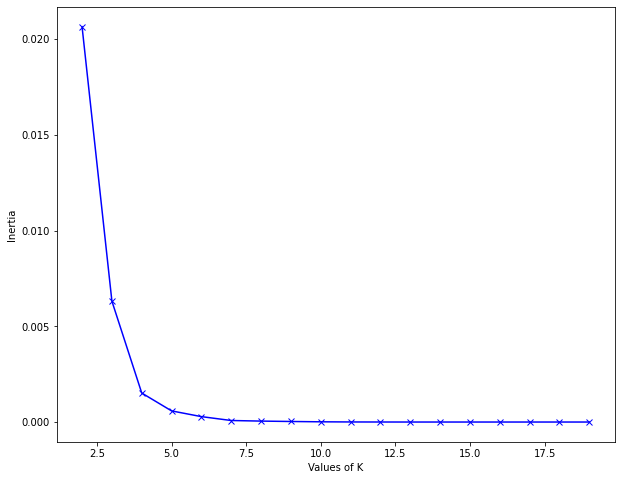

In [195]:
indian_res = indian_res.rename(columns={'Neighborhoods':'Neighborhood'})
X = indian_res.drop(['Neighborhood'], axis=1)
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.show()

Then I used the resulting k-mean to categorize my data into 10 clusters.

In [223]:
kclusters = 10
toronto_grouped_clustering = indian_res.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10]
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

Now, lets see how many neigborhoods are in each cluster.

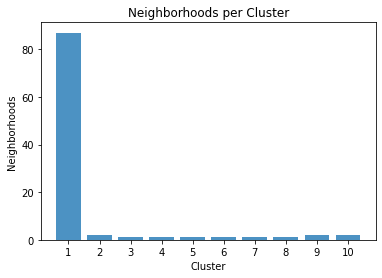

In [235]:
indian_res["Cluster Labels"] = kmeans.labels_
indian_res.head()
objects = (1,2,3,4,5,6,7,8,9,10)
y_pos = np.arange(len(objects))
performance = indian_res['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Neighborhoods')
plt.xlabel('Cluster')
plt.title('Neighborhoods per Cluster')

plt.show()
indian_res['Cluster Labels'].value_counts()
indian_res["Cluster Labels"] = kmeans.labels_

Finally, lets visualize it using Folium

In [236]:
m = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(merged_df['Neighborhood Latitude'], merged_df['Neighborhood Longitude'], merged_df['Neighborhood'], merged_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(m)
       
m

### 8. Indian Restaurants by Cluster

Now that I know how the neighborhoods in Toronto are clustered. I can analyze each cluster and find out how many indian restaurants are located in each cluster.

First, I will create a new dataframe that includes the number of Indian restaurantes in each Neighborhood and the neighborhood's coordiantes.

In [237]:
merged_df = indian_res.copy()
merged_df["Cluster Labels"] = kmeans.labels_
merged_df = merged_df.join(nearby_venues.set_index("Neighborhood"), on="Neighborhood")
merged_df.sort_values(["Cluster Labels"], inplace=True)
merged_df.head()

,Neighborhood,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
62,Ontario Provincial Government,0.0,0,43.662301,-79.389494,Queen's Park,43.663946,-79.392180,Park
61,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.0,0,43.636258,-79.498509,Robar Hardwood Flooring,43.636417,-79.493101,Home Service
61,"Old Mill South, King's Mill Park, Sunnylea, Hu...",0.0,0,43.636258,-79.498509,Woodford Park,43.633152,-79.496266,Baseball Field
60,"Northwood Park, York University",0.0,0,43.767980,-79.487262,Party City,43.764174,-79.485250,Miscellaneous Shop


Now, let's check how many Indian restaurants are there in the resulting dataframe.

In [263]:
count = merged_df['Venue Category'].value_counts()['Indian Restaurant']
indian_res["Cluster Labels"] = kmeans.labels_
print("There are",count,"Indian Restaurants in Toronto.")

There are 15 Indian Restaurants in Toronto.


I then created a dataframe for each cluster with the amount of indian restaurants in each cluster.

In [257]:
final_dataframe = df[['Borough', 'Neighborhood']]

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(final_dataframe, cluster0, on='Neighborhood')

cluster2 = to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(final_dataframe, cluster1, on='Neighborhood')

cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(final_dataframe, cluster2, on='Neighborhood')

cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(final_dataframe, cluster3, on='Neighborhood')

cluster5 = to_merged.loc[to_merged['Cluster Labels'] == 4]
df_cluster5 = pd.merge(final_dataframe, cluster4, on='Neighborhood')

cluster6 = to_merged.loc[to_merged['Cluster Labels'] == 5]
df_cluster6 = pd.merge(final_dataframe, cluster5, on='Neighborhood')

cluster7 = to_merged.loc[to_merged['Cluster Labels'] == 6]
df_cluster7 = pd.merge(final_dataframe, cluster6, on='Neighborhood')

cluster8 = to_merged.loc[to_merged['Cluster Labels'] == 7]
df_cluster8 = pd.merge(final_dataframe, cluster7, on='Neighborhood')

cluster9 = to_merged.loc[to_merged['Cluster Labels'] == 8]
df_cluster9 = pd.merge(final_dataframe, cluster8, on='Neighborhood')

cluster10 = to_merged.loc[to_merged['Cluster Labels'] == 9]
df_cluster10 = pd.merge(final_dataframe, cluster9, on='Neighborhood')

Finally, lets visualize the average amount of Indian Restaurantes per Cluster.

Text(0.5, 0, 'Cluster')

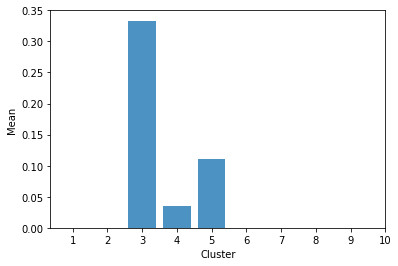

In [259]:
objects = (1,2,3,4,5,6,7,8,9,10)
clusters_mean = [df_cluster1['Indian Restaurant'].mean(),df_cluster2['Indian Restaurant'].mean(),df_cluster3['Indian Restaurant'].mean(),df_cluster4['Indian Restaurant'].mean(),
                df_cluster5['Indian Restaurant'].mean(),df_cluster6['Indian Restaurant'].mean(),df_cluster7['Indian Restaurant'].mean(),df_cluster8['Indian Restaurant'].mean(),
                df_cluster9['Indian Restaurant'].mean(),df_cluster10['Indian Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')

### 9. Conclusion

We can see that cluster 3 has the highest amount of Indian Restaurants, followed by cluster 5 and finally cluster 4. Based on my hypothesis I would safely assume that the best cluster to open an Indian Restaurant is cluster 1 since it contains the most amount of neighborhoods and the less amount of Indian Restaurants. Theoretically, an Indian Restaurant in cluster 1 would have less competition and more demand than any other cluster.

### Thanks for reading!